In [1]:
from collections import namedtuple
from typing import List

import cv2
import numpy as np

BBox = namedtuple('BBox', 'x, y, w, h')
DetectorRes = namedtuple('DetectorRes', 'img, bbox')

In [2]:
def detect_words(img: np.ndarray, kernel_size: int, sigma: int, theta: int, min_area: int) -> List[DetectorRes]:
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = get_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


In [3]:
def prepare_img(img: np.ndarray, height: int) -> np.ndarray:
    """convert given image to grayscale image (if needed) and resize to given height"""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


In [4]:
def get_kernel(kernel_size: int, sigma: int, theta: int) -> np.ndarray:
    """create anisotropic filter kernel"""
    assert kernel_size % 2  # must be odd size
    half_size = kernel_size // 2

    kernel = np.zeros([kernel_size, kernel_size])
    sigma_x = sigma
    sigma_y = sigma * theta

    # TODO: vectorize!
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - half_size
            y = j - half_size

            exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
            x_term = (x ** 2 - sigma_x ** 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
            y_term = (y ** 2 - sigma_y ** 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)

            kernel[i, j] = (x_term + y_term) * exp_term

    kernel = kernel / np.sum(kernel)
    return kernel

In [5]:
import argparse
from typing import List

import cv2
import matplotlib.pyplot as plt

In [6]:
def segment(path):
    fn_img = path

    img = prepare_img(cv2.imread(fn_img), 50)
    res = detect_words(img, kernel_size=25, sigma=11, theta=7, min_area=100)

    plt.imshow(img, cmap='gray')
    for det in res:
        xs = [det.bbox.x, det.bbox.x, det.bbox.x + det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
        ys = [det.bbox.y, det.bbox.y + det.bbox.h, det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
        plt.plot(xs, ys)
    plt.show()

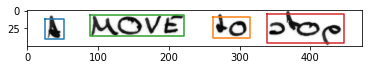

In [9]:
segment('/content/segment_no_22.png')

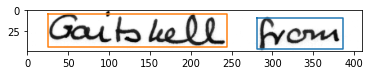

In [10]:
segment('/content/segment_no_35.png')

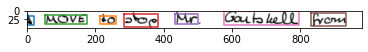

In [ ]:
segment('/content/0.png')

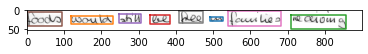

In [ ]:
segment('/content/1.png')

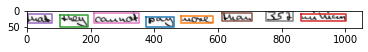

In [ ]:
segment('/content/2.png')

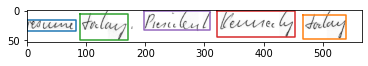

In [ ]:
segment('/content/3.png')

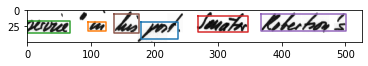

In [ ]:
segment('/content/4.png')